In [2]:
import os
from openai import OpenAI
import json
import cv2
os.environ['OPENAI_API_KEY']='insert-openai-api-key'
client = OpenAI()

In [3]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


In [4]:
import requests,time
subscription_key = "insert-azure-subscription-key"
def ocr(img,mime_type='image/jpeg'):

    """

    Ocr extraction from Image or Image at local path

    Input: Image or Image local path

    Output: Coginitive Services OCR output response json

    """

    #Change based on your server url
    url = "https://centralindia.api.cognitive.microsoft.com/vision/v3.2/read/analyze?language=en"

    payload={}

    img_bytes=None

    if type(img)==str:

        files=[('image',('tmp.jpg',open(img,"rb"),mime_type))]

    else:

        img_bytes=img

        files=[('image',('tmp.jpg',img_bytes,mime_type))]

    headers = {'Ocp-Apim-Subscription-Key': subscription_key}

    response = requests.request("POST", url, headers=headers, data=payload, files=files, verify=False)

    status_code = response.status_code

    ocr_out=response.headers

    if status_code== 202:

        url=ocr_out['Operation-Location']

        

        response = requests.request("GET", url, headers=headers, data=payload, verify=False)

        ocr_out=response.json()

        while ocr_out["status"]=="running":

            time.sleep(1)

            response = requests.request("GET", url, headers=headers, data=payload, verify=False)

            ocr_out=response.json()

    #print(ocr_out)
    return dict(ocr_out),img_bytes

In [10]:
def Image_to_JSON(image_path):
    # Perform OCR on the image and extract the text content
    result,img_bytes = ocr(image_path)
    data=result['analyzeResult']['readResults']
    texts=[line['text'] for item in data for line in item['lines']]
    
    # Stores the OCR content extracted from the image in a string which can be fed into ChatGPT
    ocr_string = " ".join(texts)
    ocr_string=ocr_string.lower()

    # Create a query for ChatGPT, including the OCR content and the required information
    ChatGPT_Query=f"""The following is a raw dump of an OCR output from a boarding pass of a flight. Extract the airline name,name of the passenger,flight number,departure city,destination city and date of departure from it. The Departure City and Destination City should be in their airport codes.
    The raw OCR data of boarding pass is {ocr_string}.
    """
    format_instructions="""The output should be in a JSON format where the keys should be 'airline_name','passenger_name','flight_num','departure_city','destination_city' and 'date_of_departure'."""
    
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo-1106",
    messages=[
    {"role": "user", "content": f"{ChatGPT_Query} \n {format_instructions}"}
    ],
    response_format={ "type": "json_object" }
    )
    # Receive the JSON file
    data = completion.choices[0].message.content

    # Return the JSON object
    return json.loads(data)

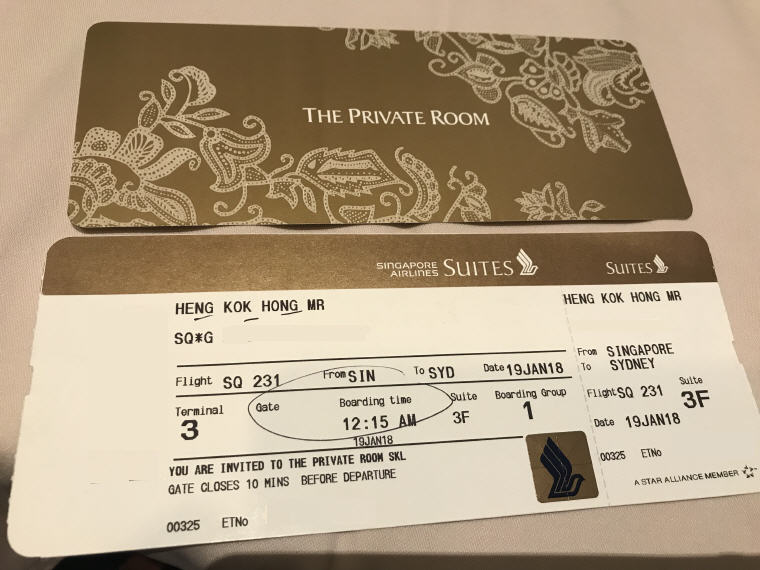

In [22]:
from IPython.display import Image
Image(filename='singapore.jpg')

In [14]:
b=Image_to_JSON(r"singapore.jpg")
import pprint #Just for demonstration purposes, can just use regular print
pprint.pprint(b)

{'airline_name': 'Singapore Airlines',
 'date_of_departure': '19Jan18',
 'departure_city': 'SIN',
 'destination_city': 'SYD',
 'flight_num': 'SQ 231',
 'passenger_name': 'Heng Kok Hong'}
